## Prompt Metadata

#### Metadata File to pandas dataframe

In [102]:
from src.utils import read_yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

from src.factories import dataLoaderFactory
from src.teacher_response_evaluator import TeacherResponseEvaluator

In [60]:
def get_meta_df(dataset: str) -> pd.DataFrame:
    metadata = read_yaml(f"prompt-metadata/{dataset}.yaml")

    # flatten metadata and convert to dataframe
    metadata = {k: {**v['costs'], **v['characteristics'], **v['performance']} for k, v in metadata.items()}
    meta_df = pd.DataFrame.from_dict(metadata, orient='index')

    # Add PALM FewShot Performance to meta_df
    # Load PALM predictions and rationales
    
    dataset_loader = dataLoaderFactory(dataset)
    train_llm_rationales, train_llm_labels = dataset_loader.load_llm_preds(split="train")

    parsed_responses = {i: (label, rational) for i, (label, rational) in enumerate(zip(train_llm_labels, train_llm_rationales))}

    evaluator = TeacherResponseEvaluator(dataset)

    label_eval = evaluator.get_label_accuracy(split="train", parsed_responses=parsed_responses)
    rationale_eval = evaluator.get_explanation_characteristics(parsed_responses=parsed_responses)

    palm_eval = {"accuracy": label_eval[0],
             "n_correct": label_eval[1],
             "n_wrong": label_eval[2],
             "n_none_responses": rationale_eval[0],
             "total_responses": rationale_eval[1],
             "total_length_of_explanations": rationale_eval[2],
             "total_number_of_sentences": rationale_eval[3],
             "total_number_of_words": rationale_eval[4],
             "flesch_reading_ease": rationale_eval[5],
             "variance_length_of_explanations": rationale_eval[6],
             "avg_len_of_explanations": rationale_eval[2] / rationale_eval[1],
             "avg_nr_of_sentences": rationale_eval[3] / rationale_eval[1],
             "avg_nr_of_words": rationale_eval[4] / rationale_eval[1],
             "n_parse_errors": 0,
             "avg_cost_per_query": 0.0033 if dataset == "anli1" else 0.00183,
             }
    
    # insert PALM evaluation into metadata dataframe with index 0
    meta_df = pd.concat([pd.DataFrame(palm_eval, index=[0]), meta_df])

    # add column with explanation rate = total responses / (n_correct + n_wrong)
    meta_df["explanation_rate"] = meta_df["total_responses"] / (meta_df["n_correct"] + meta_df["n_wrong"])
    meta_df["sd_length_of_explanations"] = meta_df["variance_length_of_explanations"] ** 0.5
    meta_df["avg_len_of_words"] = meta_df["total_length_of_explanations"] / meta_df["total_number_of_words"]
    meta_df["cost_to_data"] = meta_df["avg_cost_per_query"] * 16946 if dataset == "anli1" else meta_df["avg_cost_per_query"] * 8766

    return meta_df

In [108]:
## Check GPT35 performance on validation set
# evaluator = TeacherResponseEvaluator("anli1")
# dataset_loader = dataLoaderFactory("anli1")

# test_gpt35_rationales, test_gpt35_labels = dataset_loader.load_gpt35_preds(split="valid", prompt_mix_id=6)
# parsed_responses_gpt35 = {i: (label, rational) for i, (label, rational) in enumerate(zip(test_gpt35_labels, test_gpt35_rationales))}
# evaluator.get_label_accuracy(split="valid", parsed_responses=parsed_responses_gpt35)

(0.599, 599, 401)

In [78]:
meta_df = get_meta_df("cqa")
meta_df.head()

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,avg_len_of_explanations,avg_nr_of_sentences,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,sd_length_of_explanations,avg_len_of_words,cost_to_data
0,0.742634,7234,2507,0,9741,1291860,19502,236371,75.707027,599.220297,132.620881,2.002053,24.265578,0,0.00183,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,24.478977,5.465391,16.04178
1,0.600000,45,30,75,0,0,0,0,0.000000,NaN,0.000000,0.000000,0.000000,1,0.00015,33.25,53.35,0.010989,75.0,2494.0,4001.0,0.000000,NaN,NaN,1.31490
2,0.706700,53,22,3,72,8953,73,1526,47.100000,1197.477000,124.350000,1.010000,21.190000,2,0.00015,27.16,63.35,0.011201,75.0,2037.0,4751.0,0.960000,34.604581,5.866972,1.31490
3,0.724000,7052,2689,28,9713,1122684,9726,183730,46.600000,852.771000,115.590000,1.000000,18.920000,15,0.00018,27.65,84.36,1.993159,10962.0,303054.0,924701.0,0.997126,29.202243,6.110510,1.57788
4,0.720000,54,21,4,71,8104,73,1352,48.000000,1481.135000,114.140000,1.030000,19.040000,3,0.00018,28.81,78.28,0.013128,75.0,2161.0,5871.0,0.946667,38.485517,5.994083,1.57788


In [79]:
# sort meta_df by accuracy
pd.set_option('display.max_columns', None)
meta_df.sort_values(by=["accuracy"], ascending=False).head(10)

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,avg_len_of_explanations,avg_nr_of_sentences,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,sd_length_of_explanations,avg_len_of_words,cost_to_data
6,0.770000,77,23,89,11,1054,12,174,51.200000,3666.694000,95.820000,1.090000,15.820000,2,0.00012,12.75,60.89,0.011683,100.0,1275.0,6089.0,0.110000,60.553233,6.057471,1.05192
20,0.750000,75,25,98,2,194,2,36,0.000000,441.000000,97.000000,1.000000,18.000000,0,0.00009,5.18,52.89,0.008970,100.0,518.0,5289.0,0.020000,21.000000,5.388889,0.78894
0,0.742634,7234,2507,0,9741,1291860,19502,236371,75.707027,599.220297,132.620881,2.002053,24.265578,0,0.00183,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,24.478977,5.465391,16.04178
3,0.724000,7052,2689,28,9713,1122684,9726,183730,46.600000,852.771000,115.590000,1.000000,18.920000,15,0.00018,27.65,84.36,1.993159,10962.0,303054.0,924701.0,0.997126,29.202243,6.110510,1.57788
12,0.720000,54,21,69,6,631,6,103,45.000000,1508.139000,105.170000,1.000000,17.170000,0,0.00009,6.61,53.56,0.007017,75.0,496.0,4017.0,0.080000,38.834765,6.126214,0.78894
73,0.720000,54,21,71,4,885,6,143,41.800000,26846.188000,221.250000,1.500000,35.750000,5,0.00012,17.45,53.53,0.008640,75.0,1309.0,4015.0,0.053333,163.848064,6.188811,1.05192
27,0.720000,54,21,60,15,2520,21,408,44.400000,5629.200000,168.000000,1.400000,27.200000,0,0.00012,19.69,53.53,0.008976,75.0,1477.0,4015.0,0.200000,75.027995,6.176471,1.05192
22,0.720000,54,21,71,4,368,4,65,0.000000,1096.500000,92.000000,1.000000,16.250000,2,0.00009,7.35,51.56,0.006903,75.0,551.0,3867.0,0.053333,33.113441,5.661538,0.78894
15,0.720000,54,21,63,12,1610,15,258,47.500000,4295.472000,134.170000,1.250000,21.500000,0,0.00011,12.31,57.56,0.008322,75.0,923.0,4317.0,0.160000,65.539850,6.240310,0.96426
14,0.720000,54,21,71,4,298,4,58,0.000000,962.250000,74.500000,1.000000,14.500000,1,0.00009,6.45,54.56,0.007106,75.0,484.0,4092.0,0.053333,31.020155,5.137931,0.78894


## Plots

Text(0.5, 1.0, 'SD of Length of Explanations')

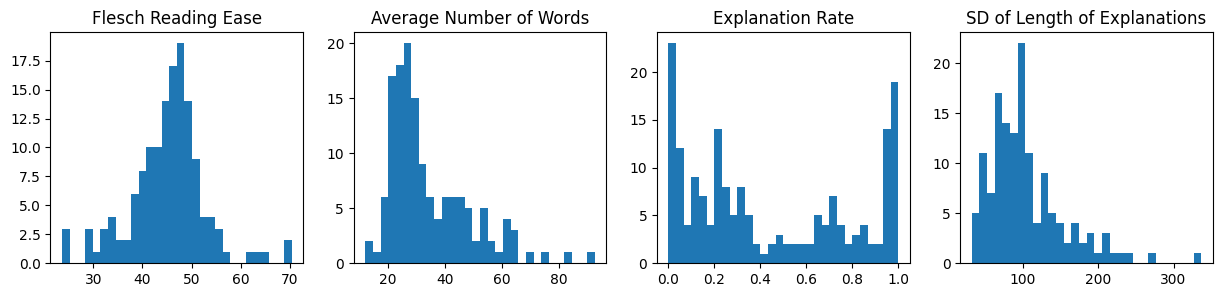

In [71]:
# histograms of: flesh reading ease, avg_nr_of_sentences, avg_nr_of_words, variance_length_of_explanations
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))
ax1.hist(meta_df[meta_df["total_responses"] >= 5]["flesch_reading_ease"], bins=30)
ax1.set_title("Flesch Reading Ease")
ax2.hist(meta_df[meta_df["total_responses"] >= 5]["avg_nr_of_words"], bins=30)
ax2.set_title("Average Number of Words")
ax3.hist(meta_df["explanation_rate"], bins=30)
ax3.set_title("Explanation Rate")
ax4.hist(meta_df[meta_df["total_responses"] >= 5]["sd_length_of_explanations"], bins=30)
ax4.set_title("SD of Length of Explanations")

Text(0.5, 1.05, 'Accuracy versus')

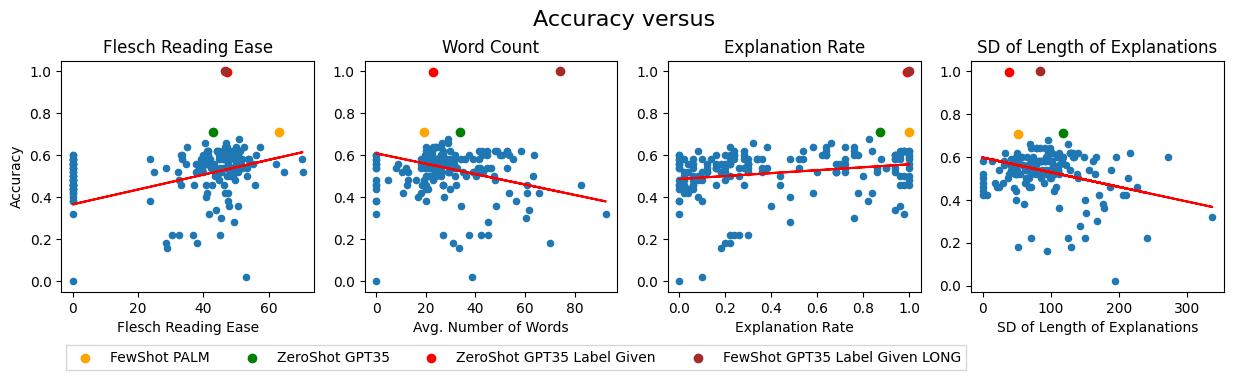

In [72]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))

reg_meta_df = meta_df[meta_df["total_responses"] >= 5].drop([0, 179, 1000], axis=0)
#reg_meta_df = meta_df[meta_df["total_responses"] >= 5].drop([0], axis=0)

meta_df.plot.scatter(x="flesch_reading_ease", y="accuracy", title="Flesch Reading Ease", ax=ax1)
slope, intercept = np.polyfit(reg_meta_df["flesch_reading_ease"], reg_meta_df["accuracy"], 1)
ax1.plot(meta_df["flesch_reading_ease"], slope*meta_df["flesch_reading_ease"] + intercept, color='red')

meta_df.plot.scatter(x="avg_nr_of_words", y="accuracy", title="Word Count", ax=ax2)
slope, intercept = np.polyfit(reg_meta_df["avg_nr_of_words"], reg_meta_df["accuracy"], 1)
ax2.plot(meta_df["avg_nr_of_words"], slope*meta_df["avg_nr_of_words"] + intercept, color='red')

meta_df.plot.scatter(x="explanation_rate", y="accuracy", title="Explanation Rate", ax=ax3)
slope, intercept = np.polyfit(reg_meta_df["explanation_rate"], reg_meta_df["accuracy"], 1)
ax3.plot(meta_df["explanation_rate"], slope*meta_df["explanation_rate"] + intercept, color='red')

meta_df.plot.scatter(x="sd_length_of_explanations", y="accuracy", title="SD of Length of Explanations", ax=ax4)
slope, intercept = np.polyfit(reg_meta_df["sd_length_of_explanations"], reg_meta_df["accuracy"], 1)
ax4.plot(meta_df["sd_length_of_explanations"], slope*meta_df["sd_length_of_explanations"] + intercept, color='red')

HIGHLIGHTS = [(0, "orange", "FewShot PALM"), (100, "green", "ZeroShot GPT35"), (179, "red", "ZeroShot GPT35 Label Given"), (1000, "brown", "FewShot GPT35 Label Given LONG")]
#HIGHLIGHTS = [(0, "orange", "FewShot PALM"), (3, "green", "ZeroShot GPT35")]


for HL  in HIGHLIGHTS:
    ax1.scatter(meta_df.loc[HL[0]]['flesch_reading_ease'], meta_df.loc[HL[0]]['accuracy'], color=HL[1], label=HL[2])
    ax2.scatter(meta_df.loc[HL[0]]['avg_nr_of_words'], meta_df.loc[HL[0]]['accuracy'], color=HL[1], label=HL[2])
    ax3.scatter(meta_df.loc[HL[0]]['explanation_rate'], meta_df.loc[HL[0]]['accuracy'], color=HL[1], label=HL[2])
    ax4.scatter(meta_df.loc[HL[0]]['sd_length_of_explanations'], meta_df.loc[HL[0]]['accuracy'], color=HL[1], label=HL[2])

#ax1.axhline(y=meta_df.iloc[0]['accuracy'], color='red', linestyle='-', lw=0.5)

ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Flesch Reading Ease")
ax2.set_ylabel("")
ax2.set_xlabel("Avg. Number of Words")
ax3.set_ylabel("")
ax3.set_xlabel("Explanation Rate")
ax4.set_ylabel("")
ax4.set_xlabel("SD of Length of Explanations")
ax1.legend(bbox_to_anchor=(1.8, -0.2), loc='upper center', ncol=4, fancybox=False)

plt.suptitle('Accuracy versus', y=1.05, fontsize=16)

Good prompts, that deliver the most accurate results, seem to produce short (between 20 and 30 words), high FRE (above 45) explanations.

There seem to be the following tendencies:
 - The lower the FRE, the lower the accuracy. So complicated explanations are not good for the prediction.
 - The longer the explanation, the lower the accuracy. So long explanations are not good for the prediction.
 - However, very short explanations (< 20 words) are also not good for the prediction.
 - Wether a prompt makes the model return an explanation at all, does not seem to have an influence on the accuracy.

### Costs

#### Estimate OPRO costs

In [80]:
#avg_cost_per_query = meta_df.drop([0, 179, 1000], axis=0)["avg_cost_per_query"].mean()
avg_cost_per_query = meta_df.drop([0], axis=0)["avg_cost_per_query"].mean()

In [81]:
avg_cost_per_query

0.0001652941176470588

In [82]:
# 100 rounds, 8 prompts per round, 25 test_size per prompt per round + 100 rounds * 8 queries of the meta prompt
opro_costs = avg_cost_per_query * 100 * 8 * 25 + 100 * 8 * 0.002

In [83]:
opro_costs

4.905882352941176

Text(0.5, 1.0, 'Total Cost to Data - CQA')

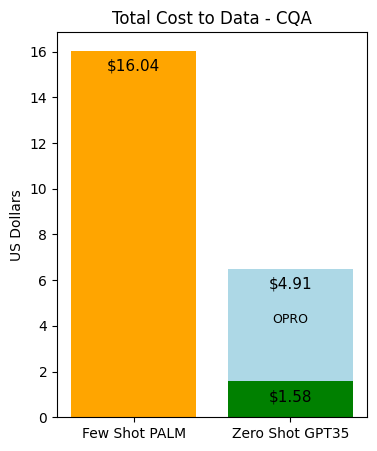

In [87]:
# plot cost_to_data of index 0 and 179 as bar chart with value on top
fig, ax = plt.subplots(figsize=(4, 5))
bars = ax.bar(x=["Few Shot PALM", "Zero Shot GPT35"], height=[0, opro_costs + meta_df.iloc[3]['cost_to_data']], color="lightblue")
for bar in bars:
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 1, f"${opro_costs:.2f}", ha='center', va='bottom', fontsize=11)
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 2.5, f"OPRO", ha='center', va='bottom', fontsize=9)

color = ['orange', 'green']
bars = ax.bar(x=["Few Shot PALM", "Zero Shot GPT35"], height=[meta_df.iloc[0]['cost_to_data'], meta_df.iloc[3]['cost_to_data']], color=color)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval - 1, f"${yval:.2f}", ha='center', va='bottom', fontsize=11)
ax.set_ylabel("US Dollars")
ax.set_title("Total Cost to Data - CQA")


## TODO: ESTIMATE CQA COST PER QUERY AND ADD OPROOOOOOOOO!!!!

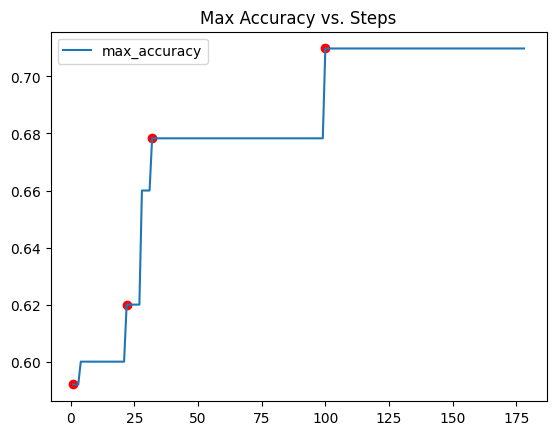

In [9]:
meta_df["max_accuracy"] = meta_df.drop([0, 179, 1000], axis=0)["accuracy"].cummax()
#meta_df["max_accuracy"] = meta_df.drop([0], axis=0)["accuracy"].cummax()
meta_df.plot.line(y="max_accuracy", title="Max Accuracy vs. Steps")

# plot a red point at index 100
plt.scatter(1, meta_df.loc[1]['max_accuracy'], color='red')
plt.scatter(22, meta_df.loc[22]['max_accuracy'], color='red')
plt.scatter(32, meta_df.loc[32]['max_accuracy'], color='red')
plt.scatter(100, meta_df.loc[100]['max_accuracy'], color='red')

#plt.scatter(1, meta_df.loc[1]['max_accuracy'], color='red')
#plt.scatter(3, meta_df.loc[3]['max_accuracy'], color='red')
#plt.scatter(6, meta_df.loc[6]['max_accuracy'], color='red')

In [10]:
pd.set_option('display.max_columns', 30)
meta_df[(meta_df["avg_nr_of_words"] > 30) & (meta_df["avg_nr_of_words"] > 70)].sort_values(by=["accuracy"], ascending=False).head(10)

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,avg_len_of_explanations,avg_nr_of_sentences,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,sd_length_of_explanations,avg_len_of_words,cost_to_data,max_accuracy
1000,0.9996,8470,3,0,8473,3782034,31511,627386,46.8,7083.481,446.36,3.72,74.05,0,0.00200,93.98,1204.90,18.951492,9498.0,892644.0,11444136.0,1.00,84.163418,6.028241,33.89200,NaN
144,0.4600,23,27,1,49,25220,199,4042,42.8,51120.172,514.69,4.06,82.49,1,0.00048,143.62,129.14,0.024048,50.0,7181.0,6457.0,0.98,226.097705,6.239485,8.13408,0.7098
26,0.3200,16,34,1,49,28614,236,4536,41.6,113655.468,583.96,4.82,92.57,1,0.00051,148.92,138.76,0.025299,50.0,7446.0,6938.0,0.98,337.128266,6.308201,8.64246,0.6200
173,0.1800,9,41,40,10,4556,31,702,28.6,16902.640,455.60,3.10,70.20,39,0.00038,93.68,125.14,0.018753,50.0,4684.0,6257.0,0.20,130.010153,6.490028,6.43948,0.7098


## Training Results

In [127]:
experiments = pd.read_csv('experiment-tracking/experiment_tracking.csv')
experiments["llm"] = experiments["llm"].fillna("None")
experiments.head()

,experiment_group,category,dataset,model,mode,llm,subsample,prompt_mix,label_type,alpha,max_input_length,batch_size,optimizer,lr,run,train_duration,train_steps,test_acc,eval_acc
0,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,0.125,0,gt,0.5,1024,64,AdamW,0.00005,0,2528.0,3750,0.349,0.347
1,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,0.250,0,gt,0.5,1024,64,AdamW,0.00005,0,3738.0,5500,0.434,0.403
2,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,0.500,0,gt,0.5,1024,64,AdamW,0.00005,0,8497.0,9500,0.346,0.342
3,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,1.000,0,gt,0.5,1024,64,AdamW,0.00005,0,5848.0,6500,0.341,0.334
4,MANUAL Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,None,0.125,0,gt,0.5,1024,64,AdamW,0.00005,100,10000.0,3750,0.349,0.347


## Subsampling

In [89]:
def subsampling_graph(experiments_data: pd.DataFrame, dataset: str, labels: bool, prompt_mix: int, distill_labels: str = None):
    # Toggle Manual Corrections
    #experiments_data = experiments_data[~experiments_data["experiment_group"].str.contains("MANUAL")]

    experiments_data = experiments_data.query("dataset == @dataset and model == 't5-v1_1-base' and prompt_mix in [0, @prompt_mix]")
    if labels:
        experiments_data = experiments_data.query("label_type == 'gt'")
    else:
        experiments_data = experiments_data.query("label_type == 'llm'")

    # group over runs and add mean and standard error over top 3 runs
    experiments_data = experiments_data.groupby(["dataset", "model", "mode", "llm", "subsample", "prompt_mix", "label_type"]).apply(
        lambda group: group.nlargest(3, "eval_acc")).reset_index(drop=True).groupby(
            ["dataset", "model", "mode", "llm", "subsample", "prompt_mix", "label_type"]).agg(
                {"train_duration": ["mean", "std"],
                "train_steps": ["mean", "std"],
                "test_acc": ["mean", "std", "sem"],
                "eval_acc": ["mean", "std", "sem", "max"]}
                )
    
    # flatten multiindex
    experiments_data.columns = ["_".join(col) for col in experiments_data.columns.ravel()]
    experiments_data = experiments_data.reset_index()

    if labels:
        standard = experiments_data.query("mode == 'standard' and llm == 'None'")
    else:
        standard = experiments_data.query("mode == 'standard' and llm == @distill_labels") ## For standard distillation we have to set labels to gpt35 or palm
    task_prefix_palm = experiments_data.query("mode == 'task_prefix' and llm == 'palm'")
    task_prefix_gpt35 = experiments_data.query("mode == 'task_prefix' and llm == 'gpt35'")

    fig, ax = plt.subplots()

    lb = "standard" if labels else f"standard ({distill_labels.upper()})"
    ax.plot(standard["subsample"], standard["eval_acc_mean"], label=lb, color="blue", marker="o")
    ax.fill_between(standard["subsample"], standard["eval_acc_mean"] - standard["eval_acc_sem"], standard["eval_acc_mean"] + standard["eval_acc_sem"], alpha=0.2)

    # add dotted horizontal line for accuracy of standard at subsample 1
    ax.axhline(y=standard[standard["subsample"] == 1.0]["eval_acc_mean"].values[0], xmin=0.0475, xmax=0.95, color='blue', linestyle='--')

    ax.plot(task_prefix_palm["subsample"], task_prefix_palm["eval_acc_mean"], label="step-by-step PALM", color="orange", marker="^")
    ax.fill_between(task_prefix_palm["subsample"], task_prefix_palm["eval_acc_mean"] - task_prefix_palm["eval_acc_sem"], task_prefix_palm["eval_acc_mean"] + task_prefix_palm["eval_acc_sem"], alpha=0.2)

    ax.plot(task_prefix_gpt35["subsample"], task_prefix_gpt35["eval_acc_mean"], label=f"step-by-step GPT35 ({prompt_mix})", color="green", marker="d")
    ax.fill_between(task_prefix_gpt35["subsample"], task_prefix_gpt35["eval_acc_mean"] - task_prefix_gpt35["eval_acc_sem"], task_prefix_gpt35["eval_acc_mean"] + task_prefix_gpt35["eval_acc_sem"], alpha=0.2)

    # set x ticks to subsample values and add grid lines to x and y axis
    ax.set_xticks(standard["subsample"])
    ax.grid(axis="x")
    ax.grid(axis="y")

    title = "Finetuning - Eval Accuracy vs. Subsample" if labels else f"Distillation - Eval Accuracy vs. Subsample"
    ax.set_title(title)
    ax.set_ylabel("Eval Accuracy")
    ax.set_xlabel("Subsample")
    ax.legend()

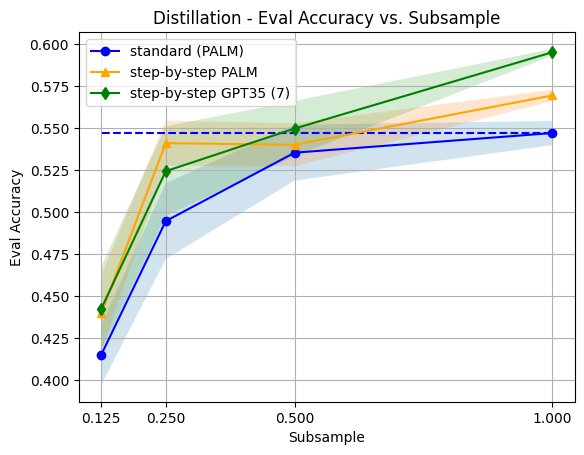

In [15]:
subsampling_graph(experiments, dataset="cqa", labels=False, prompt_mix=7, distill_labels="palm")

## Model Size

In [123]:
def modelsize_graph(experiments_data: pd.DataFrame, dataset: str, labels: bool, prompt_mix: int, distill_labels: str = None):
    # replace nan with "None"
    experiments_data["llm"] = experiments_data["llm"].fillna("None")

    experiments_data = experiments_data.query("dataset == @dataset and subsample == 1.0 and prompt_mix in [0, @prompt_mix]")
    if labels:
        experiments_data = experiments_data.query("label_type == 'gt'")
    else:
        experiments_data = experiments_data.query("label_type == 'llm'")

    # group over runs and add mean and standard error over top 3 runs
    experiments_data = experiments_data.groupby(["dataset", "model", "mode", "llm", "subsample", "prompt_mix", "label_type"]).apply(
        lambda group: group.nlargest(3, "eval_acc")).reset_index(drop=True).groupby(
            ["dataset", "model", "mode", "llm", "subsample", "prompt_mix", "label_type"]).agg(
                {"train_duration": ["mean", "std"],
                "train_steps": ["mean", "std"],
                "test_acc": ["mean", "std", "sem"],
                "eval_acc": ["mean", "std", "sem", "max"]}
                )
    
    # flatten multiindex
    experiments_data.columns = ["_".join(col) for col in experiments_data.columns.ravel()]
    experiments_data = experiments_data.reset_index()

    # add int model size column
    sizes = {"t5-v1_1-base": 250, "t5-v1_1-small": 77, "t5-v1_1-large": 800, "t5-v1_1-xl": 3000}
    experiments_data["model_size"] = experiments_data["model"].map(sizes)

    # sort by model size
    experiments_data = experiments_data.sort_values(by=["model_size"])

    if labels:
        standard = experiments_data.query("mode == 'standard' and llm == 'None'")
    else:
        standard = experiments_data.query("mode == 'standard' and llm == @distill_labels") ## For standard distillation we have to set labels to gpt35 or palm
    task_prefix_palm = experiments_data.query("mode == 'task_prefix' and llm == 'palm'")
    task_prefix_gpt35 = experiments_data.query("mode == 'task_prefix' and llm == 'gpt35'")

    fig, ax = plt.subplots()

    lb = "standard" if labels else f"standard ({distill_labels.upper()})"
    ax.plot(standard["model_size"], standard["eval_acc_mean"], label=lb, color="blue", marker="o")
    ax.fill_between(standard["model_size"], standard["eval_acc_mean"] - standard["eval_acc_sem"], standard["eval_acc_mean"] + standard["eval_acc_sem"], alpha=0.2)

    ax.plot(task_prefix_palm["model_size"], task_prefix_palm["eval_acc_mean"], label="step-by-step PALM", color="orange", marker="^")
    ax.fill_between(task_prefix_palm["model_size"], task_prefix_palm["eval_acc_mean"] - task_prefix_palm["eval_acc_sem"], task_prefix_palm["eval_acc_mean"] + task_prefix_palm["eval_acc_sem"], alpha=0.2)

    ax.plot(task_prefix_gpt35["model_size"], task_prefix_gpt35["eval_acc_mean"], label=f"step-by-step GPT35 ({prompt_mix})", color="green", marker="d")
    ax.fill_between(task_prefix_gpt35["model_size"], task_prefix_gpt35["eval_acc_mean"] - task_prefix_gpt35["eval_acc_sem"], task_prefix_gpt35["eval_acc_mean"] + task_prefix_gpt35["eval_acc_sem"], alpha=0.2)

    # set x ticks to subsample values and add grid lines to x and y axis
    ax.set_xticks(standard["model_size"])
    ax.set_xticklabels(["77M", "250M", "800M", "3B"], rotation=45)
    ax.grid(axis="x")
    ax.grid(axis="y")

    # add GPT35 Eval Accuracy
    gpt_35_eval_acc = 0.599 if dataset == "anli1" else 0.724
    ax.axhline(y=gpt_35_eval_acc, xmin=0.0475, xmax=0.95, color='red', linestyle='--', label="Teacher")

    title = "Finetuning - Eval Accuracy vs. Model Size" if labels else f"Distillation - Eval Accuracy vs. Model Size"
    ax.set_title(title)
    ax.set_ylabel("Eval Accuracy")
    ax.set_xlabel("Model Size")
    ax.legend()

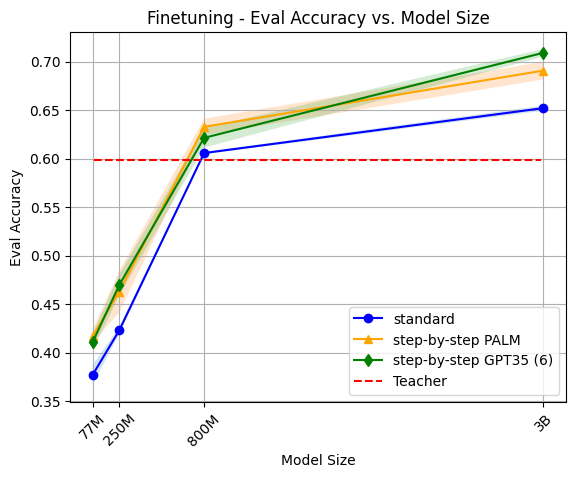

In [129]:
modelsize_graph(experiments, dataset="anli1", labels=True, prompt_mix=6, distill_labels="palm")

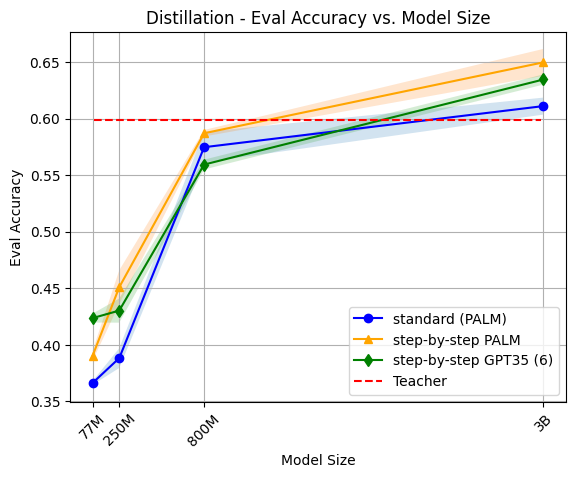

In [130]:
modelsize_graph(experiments, dataset="anli1", labels=False, prompt_mix=6, distill_labels="palm")

## Explanation Sytle
### Length

In [131]:
def plot_explanation_length(experiments: pd.DataFrame, subsample:float=0.5):
    filtered_exp_length_cp = experiments.copy()
    # for prompt_mix 9, change subsample 1.0 to 0.5
    filtered_exp_length_cp.loc[(filtered_exp_length_cp["prompt_mix"] == 9), "subsample"] = 0.5

    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), sharey=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
    models = ["t5-v1_1-small", "t5-v1_1-base", "t5-v1_1-large"]
    model_sizes = ["77M", "250M", "800M"]
    for ax, model, size in zip([ax1, ax2, ax3], models, model_sizes):
        
        filtered_exp_length = filtered_exp_length_cp.query(f"dataset == 'anli1' and model == @model and subsample == {subsample} and label_type == 'gt' and mode == 'task_prefix'")
        
        # group over runs and add mean and standard error over top 3 runs
        filtered_exp_length = filtered_exp_length.groupby(["prompt_mix"]).apply(
            lambda group: group.nlargest(3, "eval_acc")).reset_index(drop=True)

        lens = {0: 19, 6: 34, 8: 23, 9: 74}
        filtered_exp_length["avg_x_len"] = filtered_exp_length["prompt_mix"].map(lens)
        filtered_exp_length = filtered_exp_length.sort_values(by=["avg_x_len"])

        # vertical boxplots of eval_acc for each avg_x_len.
        positions = sorted(lens.values()) if subsample == 0.5 else sorted(lens.values())[:-1]
        colors = ["orange", "red", "green", "brown"] if subsample == 0.5 else ["orange", "red", "green"]
        bplot = filtered_exp_length.boxplot(column="eval_acc", by="avg_x_len", ax=ax, positions=positions, grid=True, widths=3.0, patch_artist=True, 
                                            boxprops=dict(edgecolor="black"),
                                            medianprops=dict(color="black", linewidth=1),
                                            meanprops=dict(color="black", linewidth=1),
                                            whiskerprops=dict(color="black"),
                                            showfliers=False,
                                            showmeans=True, meanline=True)
        boxes = [child for child in bplot.get_children() if isinstance(child, matplotlib.patches.PathPatch)]
        for box, color in zip(boxes, colors):
            box.set_facecolor(color)

        ax.plot(positions, filtered_exp_length.groupby(["avg_x_len"]).agg({"eval_acc": "mean"}), color="black", marker="")
        ax.set_title(f"{size} Parameters")
        ax.set_xlabel("Avg. Explanation Length (Words)")
        
    ax1.set_ylabel("Accuracy")
    fig.suptitle(f"Eval Accuracy vs. Average Length of Explanation across Model Sizes (SubSample={subsample})", y=1.05, fontsize=16)

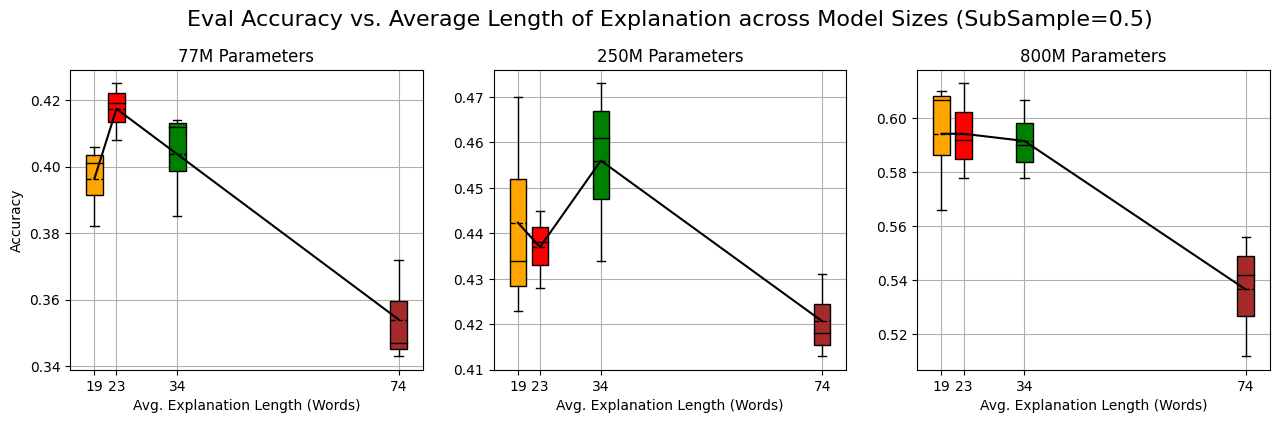

In [132]:
plot_explanation_length(experiments, subsample=0.5)

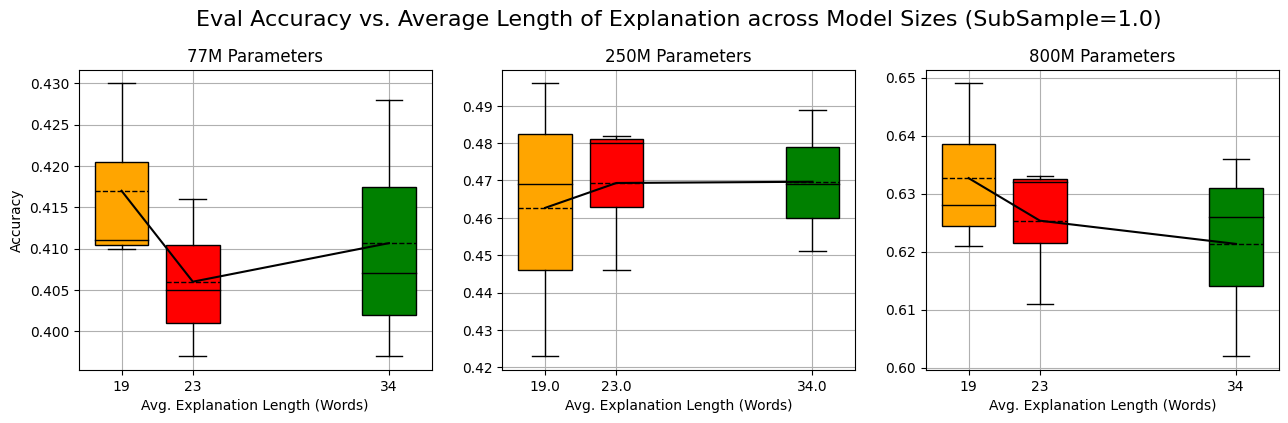

In [133]:
plot_explanation_length(experiments, subsample=1.0)

### FRE and Standard Deviation

In [136]:
def plot_scatter(experiments:pd.DataFrame):
    filtered_exp_length_cp = experiments.copy()
    # for prompt_mix 9, change subsample 1.0 to 0.5
    filtered_exp_length_cp.loc[(filtered_exp_length_cp["prompt_mix"] == 9), "subsample"] = 0.5

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3.5), sharey=False)
    #norm = Normalize(vmin=0.406, vmax=0.632)


    models = ["t5-v1_1-small", "t5-v1_1-base", "t5-v1_1-large"]
    model_sizes = ["77M", "250M", "800M"]
    for ax, model, size in zip([ax1, ax2, ax3], models, model_sizes):
        
        filtered_exp_length = filtered_exp_length_cp.query(f"dataset == 'anli1' and model == @model and subsample == 1.0 and label_type == 'gt' and mode == 'task_prefix' and prompt_mix in [0, 6, 8]")
        
        # group over runs and add mean and standard error over top 3 runs
        filtered_exp_length = filtered_exp_length.groupby(["prompt_mix"]).apply(
            lambda group: group.nlargest(3, "eval_acc")).reset_index(drop=True)
        
        filtered_exp_length = filtered_exp_length.groupby(
            ["prompt_mix"]).agg(
                {"train_duration": ["mean", "std"],
                "train_steps": ["mean", "std"],
                "test_acc": ["mean", "std", "sem"],
                "eval_acc": ["mean", "std", "sem", "max"]}
                )
        
        filtered_exp_length.columns = ["_".join(col) for col in filtered_exp_length.columns.ravel()]
        filtered_exp_length = filtered_exp_length.reset_index()

        lens = {0: 19, 6: 34, 8: 23}
        FREs = {0: 63, 6: 43, 8: 47}
        SDs = {0: 51, 6: 118, 8: 38}
        colors = {0: "orange", 6: "green", 8: "red"}
        filtered_exp_length["avg_x_len"] = filtered_exp_length["prompt_mix"].map(lens)
        filtered_exp_length["fre"] = filtered_exp_length["prompt_mix"].map(FREs)
        filtered_exp_length["sd"] = filtered_exp_length["prompt_mix"].map(SDs)
        filtered_exp_length["color"] = filtered_exp_length["prompt_mix"].map(colors)
        filtered_exp_length["size"] = (filtered_exp_length["avg_x_len"] - filtered_exp_length["avg_x_len"].min()) / (filtered_exp_length["avg_x_len"].max() - filtered_exp_length["avg_x_len"].min()) * 500 + 50
        
        filtered_exp_length.plot.scatter(x="sd", y="fre", s="size", c="eval_acc_mean",
                                        ax=ax,
                                        cmap='winter', colorbar=False,)
        ax.set_xticks(sorted(SDs.values()))
        ax.set_xlim([30, 129])
        ax.set_xlabel("SD of Length of Explanations")
        ax.set_yticks(sorted(FREs.values()))
        ax.set_ylim([40, 65])
        ax.grid()
        ax.set_title(f"{size} Parameters")
        ax.set_ylabel("")
        # add color legend
        fig.colorbar(ax.collections[0], ax=ax, label="", orientation="vertical", pad=0.03, shrink=0.7, ticks=[0.406, 0.411, 0.417, 0.463, 0.469, 0.622, 0.625, 0.632])
        
    
    # Create proxy artists for the legend
    sizes = [10, 16, 22]  # Adjust based on your actual size values
    markers = [plt.Line2D([0,0],[0,0], marker='o', color='w', markerfacecolor='blue', markersize=size) for size in sizes]
    labels = [f'{le} Words' for le in [19, 23, 34]]

    ax1.set_ylabel("Flesch Reading Ease")
    ax1.legend(handles=markers, labels=labels, title='Explanation Length', loc='upper left', bbox_to_anchor=(-0.05, -0.15), fontsize=8, ncol=3)
    fig.suptitle(f"Eval Accuracy vs. Flesch Reading Ease and SD of Length of Explanations", y=1.05, fontsize=16)

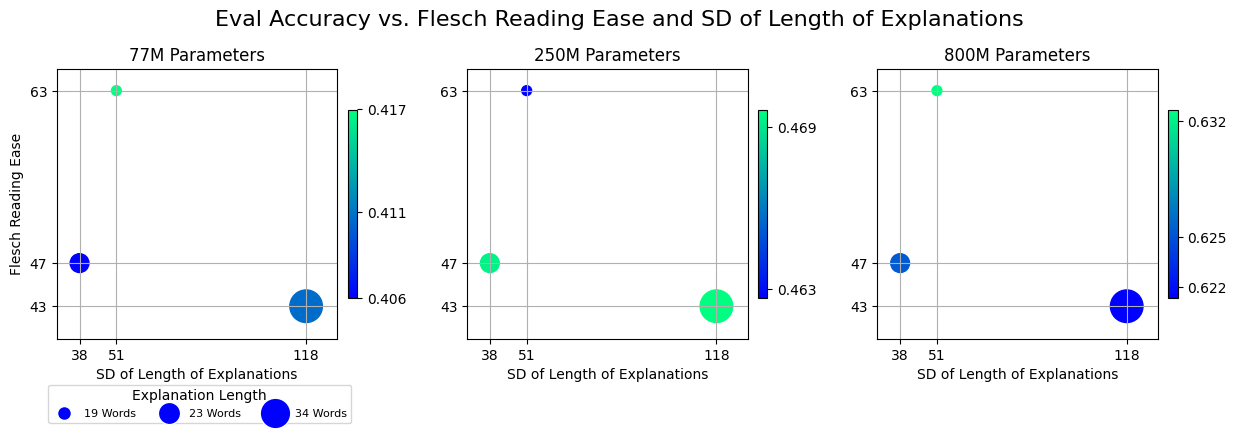

In [246]:
plot_scatter(experiments)

### Explanation Rate

Text(0.5, 0.98, '')

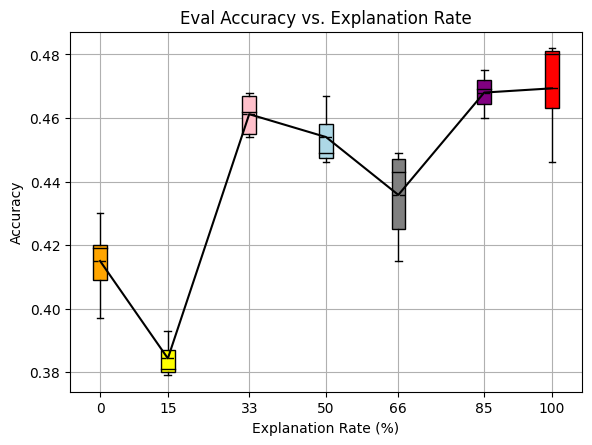

In [135]:
filtered_exp_rate = experiments.copy()

filtered_exp_rate = filtered_exp_rate.query("(dataset == 'anli1' and model == 't5-v1_1-base' and subsample == 1.0 and label_type == 'gt' and mode == 'task_prefix' and prompt_mix in [8, 10, 11, 12, 13, 14]) or (dataset == 'anli1' and model == 't5-v1_1-base' and subsample == 1.0 and label_type == 'gt' and mode == 'standard' and prompt_mix == 0)")


# group over runs and add mean and standard error over top 3 runs
filtered_exp_rate = filtered_exp_rate.groupby(["prompt_mix"]).apply(
    lambda group: group.nlargest(5, "eval_acc")).reset_index(drop=True)

xr = {0: 0, 8: 100, 10: 66, 11: 33, 12: 50, 13: 15, 14: 85}
filtered_exp_rate["xr"] = filtered_exp_rate["prompt_mix"].map(xr)
filtered_exp_rate = filtered_exp_rate.sort_values(by=["xr"])

fig, ax = plt.subplots()

positions = sorted(xr.values())
colors = ["orange", "yellow", "pink", "lightblue", "grey", "purple", "red"]
#colors = ["orange", "red", "red", "red", "red", "red", "red"]
bplot = filtered_exp_rate.boxplot(column="eval_acc", by="xr", ax=ax, positions=positions, grid=True, widths=3.0, patch_artist=True, 
                                    boxprops=dict(edgecolor="black"),
                                    medianprops=dict(color="black", linewidth=1),
                                    meanprops=dict(color="black", linewidth=1),
                                    whiskerprops=dict(color="black"),
                                    showfliers=False,
                                    showmeans=True, meanline=True)
boxes = [child for child in bplot.get_children() if isinstance(child, matplotlib.patches.PathPatch)]
for box, color in zip(boxes, colors):
    box.set_facecolor(color)

ax.plot(positions, filtered_exp_rate.groupby(["xr"]).agg({"eval_acc": "mean"}), color="black", marker="")
ax.set_title("Eval Accuracy vs. Explanation Rate")
ax.set_xlabel("Explanation Rate (%)")
ax.set_ylabel("Accuracy")
fig.suptitle("")